In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

import sys
sys.path.insert(0, '..')
from prompteval.methods import StratSample, ExtendedRaschModel

In [2]:
models = ['cohere',
          'Qwen1.5-7B-Chat',
          'Mistral-7B-Instruct-v0.2',
          'llama-2-70b-chat-hf']

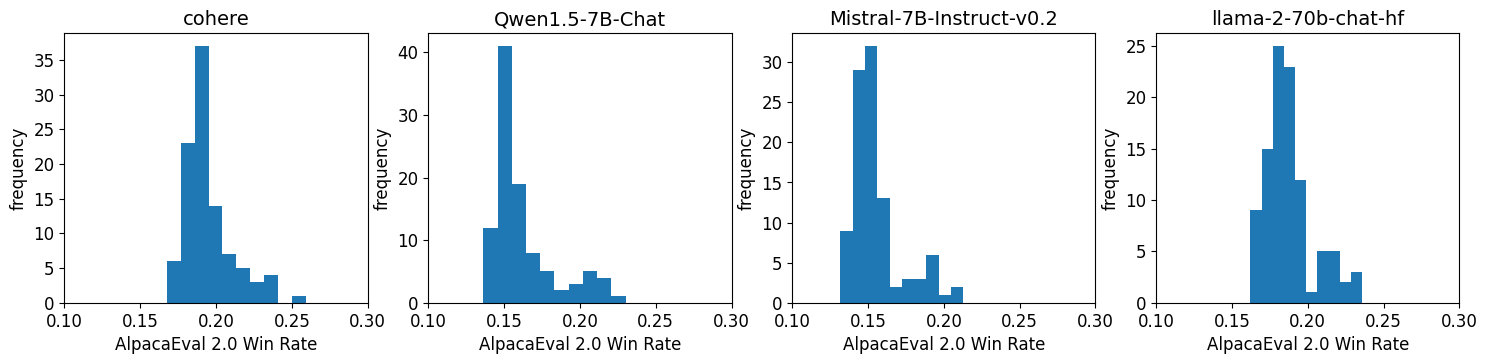

In [4]:
# Define the number of subplots based on the number of models
num_models = len(models)
fig, axes = plt.subplots(1, len(models), figsize=(18, 3.5))
Ys = {}
for i, model in enumerate(models):
    Ys[model] = []
    accs = []
    for j in range(100):
        path = f"../data/AlpacaEval_outputs/{model}/annotations_{j}.json"
        try:
            with open(path) as f:
                data = json.load(f)
            y = (np.array([d['preference'] for d in data])-1)
            accs.append(y.mean())
        except:
            break
        Ys[model].append(y) 
    Ys[model] = np.array(Ys[model])
    if model != 'llama-2-70b-chat-hf':  # llama didn't have this question
        Ys[model] = np.delete(Ys[model], 691, 1)
    
    # Plot histogram on the i-th subplot
    ax = axes[i]
    ax.hist(accs)
    ax.set_title(model, fontsize=14)
    ax.set_xlim(.1, 0.3)
    ax.set_xlabel("AlpacaEval 2.0 Win Rate", fontsize=12)
    ax.set_ylabel('frequency', fontsize=12)
    ax.tick_params(axis='x', labelsize=12)  # Adjust fontsize as needed
    # Optionally set ytick label size as well
    ax.tick_params(axis='y', labelsize=12)

plt.subplots_adjust(wspace=0.2)
plt.savefig(f'../plots/llm_judge_exp_hists.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()


In [5]:
len(Ys.values())

4

In [6]:
c=.5

In [7]:
accs = np.array([Y.mean(1) for Y in Ys.values()])
accs_bin = np.array([(Y>=c).astype(int).mean(1) for Y in Ys.values()])
norm_accs = (accs-accs.min(1)[:,None])/(accs.max(1)[:,None]-accs.min(1)[:,None])

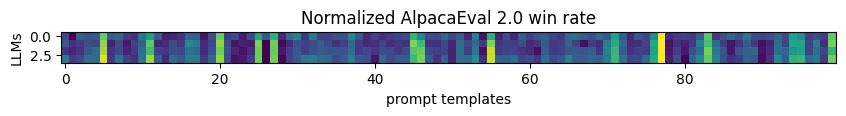

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(norm_accs)
plt.xlabel('prompt templates')
plt.ylabel('LLMs')
plt.title('Normalized AlpacaEval 2.0 win rate')
plt.savefig(f'../plots/heatmap_winrate_alpaca.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

In [9]:
np.abs(accs-accs_bin).mean()

0.0021149695360404225

In [10]:
np.unique(accs.T.argsort(1), axis=0, return_counts=True)

(array([[1, 2, 0, 3],
        [1, 2, 3, 0],
        [2, 1, 0, 3],
        [2, 1, 3, 0]]),
 array([ 1, 13, 22, 64]))

Using PromptEval

In [21]:
%%time
budget = 1600
seen_examples = StratSample(np.zeros(Ys[models[0]].shape).astype(bool), budget, random_seed=0)

CPU times: user 534 ms, sys: 5.16 ms, total: 539 ms
Wall time: 530 ms


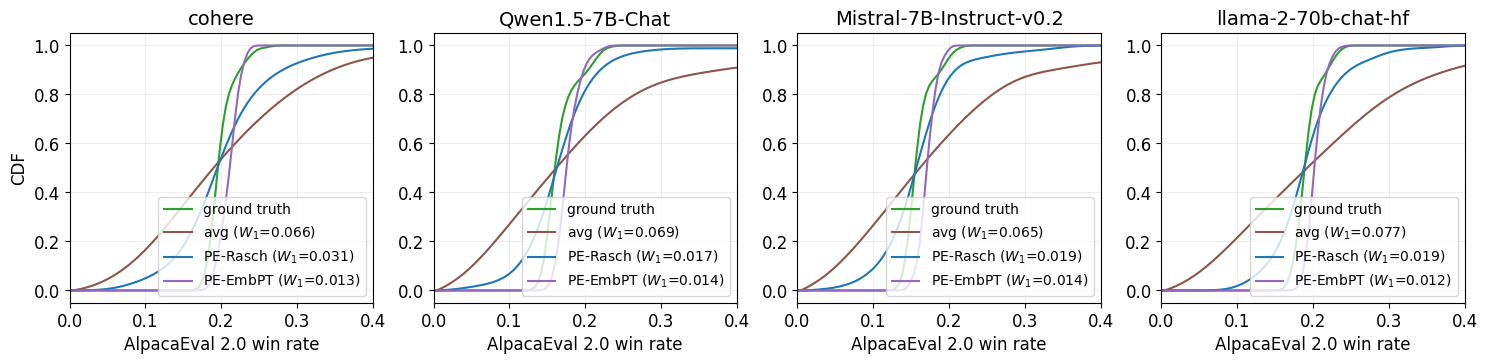

In [22]:
X_emb = np.load('../data/embeddings_llm_judge.npy')

fig, axes = plt.subplots(1, len(models), figsize=(18, 3.5))

for ax, model in zip(axes, models):
    Y_seen = (Ys[model]>=c).astype(int)
    Y_seen[~seen_examples] = -99  # just a placeholder for non-observed

    extended_rasch = ExtendedRaschModel()
    extended_rasch.fit(seen_examples, Y_seen)
    extended_rasch_cov = ExtendedRaschModel()
    extended_rasch_cov.fit(seen_examples, Y_seen, X_emb)
    
    S = Ys[model].mean(1)
    S_hat = extended_rasch.get_Y_hat().mean(1)
    S_hat_baseline = [Y_seen[i, s].mean() for i, s in enumerate(seen_examples)]
    S_hat_cov = extended_rasch_cov.get_Y_hat().mean(1)
    
    # Define the range for the KDE
    x = np.linspace(0, .4, 100)

    # Kernel density estimation
    kde_S = gaussian_kde(S)
    kde_S_hat_baseline = gaussian_kde(S_hat_baseline)
    kde_S_hat = gaussian_kde(S_hat)
    kde_S_hat_cov = gaussian_kde(S_hat_cov)
    
    # Compute the CDF
    cdf_S = [np.trapz(kde_S(x[:i]),x[:i]) for i in range(len(x))]
    cdf_S_hat_baseline = [np.trapz(kde_S_hat_baseline(x[:i]),x[:i]) for i in range(len(x))]
    cdf_S_hat = [np.trapz(kde_S_hat(x[:i]),x[:i]) for i in range(len(x))]
    cdf_S_hat_cov = [np.trapz(kde_S_hat_cov(x[:i]),x[:i]) for i in range(len(x))]
    
    ax.plot(x, cdf_S, linewidth=1.5, color='#2ca02c', label='ground truth')
    ax.plot(x, cdf_S_hat_baseline, linewidth=1.5, color='#8c564b', label=f'avg ($W_1$={np.abs(np.sort(S) - np.sort(S_hat_baseline)).mean():.3f})')
    ax.plot(x, cdf_S_hat, linewidth=1.5, color='#1f77b4', label=f'PE-Rasch ($W_1$={np.abs(np.sort(S) - np.sort(S_hat)).mean():.3f})')
    ax.plot(x, cdf_S_hat_cov, linewidth=1.5, color='#9467bd', label=f'PE-EmbPT ($W_1$={np.abs(np.sort(S) - np.sort(S_hat_cov)).mean():.3f})')
    ax.set_xlim(0, .4)
    ax.legend(fontsize=10, loc='lower right')
    ax.set_title(f'{model}', fontsize=14)
    ax.set_xlabel("AlpacaEval 2.0 win rate", fontsize=12)
    ax.grid(alpha=.2)

    # Set xtick label size
    ax.tick_params(axis='x', labelsize=12)  # Adjust fontsize as needed
    # Optionally set ytick label size as well
    ax.tick_params(axis='y', labelsize=12)
    
axes[0].set_ylabel("CDF", fontsize=12)
plt.subplots_adjust(wspace=0.2)
plt.savefig(f'../plots/llm_judge_exp.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()